<a href="https://colab.research.google.com/github/Tikquuss/word_embeddings/blob/main/Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[GloVe ](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation)  in pytorch**

# **Theory**

GloVe, coined from Global Vectors, is a model for distributed word representation. The model is an unsupervised learning algorithm for obtaining vector representations for words. The GloVe model learns word vectors by examining word co-occurrences within a text corpus.  

Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$. Let $X_i = \sum_k X_{ik}$ be the number of times any word appears
in the context of word $i$. Finally, let $P_{ij} = X_{ij}/X_i$ be the probability that word $j$ appear in the context of word $i$.

The relationship between two words $i$ and $j$ can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$. For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large. Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one. 

An example relating to the concepts of thermodinamics is given in the original paper with $i = ice$, $j = steam$ and $k \in \{solid, gas, water, fashion\}$

The above argument suggests that the appropriate starting point for word vector learning should be with ratios of co-occurrence probabilities rather than the probabilities themselves. Noting that the ratio $P_{ik}/P_{jk}$ depends on three words $i$, $j$, and $k$, the most general model takes the form $F(w_i, w_j, \tilde{w}_k) = P_{ik}/P_{jk}$ where $w \in \mathbb{R}^d$ are word vectors and $\tilde{w} \in \mathbb{R}^d$ are separate context word vectors.

To enforce $F$ to encode the information present the ratio $P_{ik}/P_{jk}$ in the word vector space, the authors restrict $F$
to depend only on the difference of the two target words $i$ and $j$, since vector spaces are inherently linear structures.
To also avoid $F$ to obfuscate the linear structure we are trying to capture as it transforms vectors into scalars, the authors passed the dot product $(w_i - w_j)^T \tilde{w}_k$ as an $F$ parameter instead of $w_i - w_j$ and $\tilde{w}_k$ themselves.

$$F((w_i - w_j)^T \tilde{w}_k) = P_{ik}/P_{jk}$$ $\text{ then }$ $$F(w_i^T \tilde{w}_k) = P_{ik} = X_{ik}/X_i \text{ (1)}$$

The authors require that $F$ be a homomorphism between the groups $(\mathbb{R},+)$ and $(\mathbb{R}_{>0}, ×)$, i.e.,

$$F((w_i - w_j)^T \tilde{w}_k) = F(w_i^T \tilde{w}_k - w_j^T \tilde{w}_k) = \frac{F(w_i^T \tilde{w}_k)}{F(w_j^T \tilde{w}_k)}$$ $\text{ then }$ $$F = exp \text{ (2)}$$

$$\text{(1) and (2)} \Rightarrow w_i^T \tilde{w}_k = log(P_{ik}) = log(X_{ik}) - log(X_i)$$
 
We will then produce vectors with a soft constraint that for each word pair of word $i$ and word $j$

$$w_i^T \tilde{w}_j + b_i + \tilde{b}_j = \log X_{ij}$$

where $b_i$ and $\tilde{b}_j$ are scalar bias terms associated with words $i$ and $j$, respectively. 

We’ll do this by minimizing an objective function $J$, which evaluates the sum of all squared errors based on the above equation, weighted with a function $f$:

$$J=\sum_{i=1}^{V} \sum_{j=1}^{V} f(X_{ij}) (w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log X_{ij})^2$$

We choose an $f$ that helps prevents common word pairs (i.e., those with large $X_{ij}$ values) from skewing our objective too much:
$$
f(X_{ij}) = \left\{
    \begin{array}{ll}
        \bigg(\frac{X_{ij}}{x_{max}}\bigg)^{\alpha} & \mbox{if } X_{ij} \lt x_{max} \\
        1 & \mbox{otherwise}
    \end{array}
\right.
$$

When we encounter extremely common word pairs (where $X_{ij} \gt x_{max}$) this function will cut off its normal output and simply return $1$. For all other word pairs, we return some weight in the range $(0,1)$, where the distribution of weights in this range is decided by $\alpha$.

The authors use $x_{max} = 100 \text{ and } \alpha = 3/4$

Before starting, we advise you to see this [notebook](https://github.com/spro/practical-pytorch/blob/master/glove-word-vectors/glove-word-vectors.ipynb) illustrating the use of pre-trained models with pytorch.

# **Implementation**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Before we train the actual model, we need to construct a co-occurrence matrix $X$, where a cell $X_{ij}$ is a “strength” which represents how often the word $i$ appears in the context of the word $j$. We run through our corpus just once to build the matrix $X$, and from then on use this co-occurrence data in place of the actual corpus. We will construct our model based only on the values collected in $X$.

In [ ]:
def build_cooccur(corpus, vocab = None, context_size = 10, min_count = None) :
   
    # Create tokenized text (list) and vocabulary (set of unique words)
    token_text = word_tokenize(corpus)
    len_token_text = len(token_text)

    print("# of tokens: ", len(token_text), '\n', token_text[:10])

    # set of vocab items
    if vocab is None :
        vocab = set(token_text)

    vocab_size = len(vocab)
    print("size of vocabulary: ", vocab_size)

    # dictionaries mapping from word to index and vica versa
    word_to_ix = {word: i for i, word in enumerate(vocab)}
    ix_to_word = {i: word for i, word in enumerate(vocab)}

    # Construct co-occurence matrix
    co_occ_mat = np.zeros((vocab_size, vocab_size))
    for i in range(len_token_text):
        ix = word_to_ix[token_text[i]]
        for dist in range(1, context_size + 1):
            if i - dist > 0:
                left_ix = word_to_ix[token_text[i - dist]]
                co_occ_mat[ix, left_ix] += 1.0 / dist
            if i + dist < len_token_text:
                right_ix = word_to_ix[token_text[i + dist]]
                co_occ_mat[ix, right_ix] += 1.0 / dist

    print("shape of co-occurrence matrix:", co_occ_mat.shape)

    return co_occ_mat, vocab, len_token_text

Once we’ve prepared $X$, our task is to decide vector values in continuous space for each word we observe in the corpus. Intuitively speaking, we want to build word vectors that retain some useful information about how every pair of words $i$ and $j$ co-occur.

In [ ]:
class Glove(nn.Module):

    def __init__(self, vocab : set, len_token_text : int, comat, embedding_size, x_max, alpha, batch_size):
        super(Glove, self).__init__()
        
        self.len_token_text = len_token_text
        unk = "unk"
        vocab = {unk}.union(vocab)
        self.vocab = vocab
        vocab_size = len(vocab)
        self.vocab_size = vocab_size
        self.word_to_ix = {word: i for i, word in enumerate(vocab)}
        self.ix_to_word = {i: word for i, word in enumerate(vocab)}
        self.unk_id = self.word_to_ix["unk"]

        # embedding matrices
        self.embedding_V = nn.Embedding(vocab_size, embedding_size) # embedding matrix of center words
        self.embedding_U = nn.Embedding(vocab_size, embedding_size) # embedding matrix of context words

        # biases
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
        # initialize all params
        for params in self.parameters():
            nn.init.uniform_(params, a = -0.5, b = 0.5)
            
        #hyperparams
        self.x_max = x_max
        self.alpha = alpha
        self.comat = comat
        # Non-zero co-occurrences
        # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.nonzero.html
        # returns a 2-D array, with a row for each non-zero element            
        self.co_occs = np.transpose(np.nonzero(comat))
        #print("non-zero co-occurrences:\n", self.co_occs)

        self.batch_size = batch_size
    
    def forward(self, center_word_lookup, context_word_lookup):
        # indexing into the embedding matrices
        center_embed = self.embedding_V(center_word_lookup)
        target_embed = self.embedding_U(context_word_lookup)

        center_bias = self.v_bias(center_word_lookup).squeeze(1)
        target_bias = self.u_bias(context_word_lookup).squeeze(1)

        # elements of the co-occurence matrix
        co_occurrences = torch.tensor([self.comat[center_word_lookup[i].item(), context_word_lookup[i].item()]
                                       for i in range(self.batch_size)])
        
        # weight_fn applied to non-zero co-occurrences
        weights = torch.tensor([self.weight_fn(var) for var in co_occurrences])

        # the loss as described in the paper
        loss = torch.sum(torch.pow((torch.sum(center_embed * target_embed, dim=1)
            + center_bias + target_bias) - torch.log(co_occurrences), 2) * weights)
        
        return loss
        
    def weight_fn(self, x):
        # the proposed weighting fn
        if x < self.x_max:
            return (x / self.x_max) ** self.alpha
        return 1
        
    def embeddings(self):
        # "we choose to use the sum W + W_tilde as our word vectors"
        return self.embedding_V.weight.data + self.embedding_U.weight.data

    # Batch sampling function
    def gen_batch(self):
        """
        picks random indices for lookup in the embedding matrix
        "stochastically sampling non-zero elements from X [ie. the co-occurrence matrix]"
        """	
        sample = np.random.choice(np.arange(len(self.co_occs)), size = self.batch_size, replace=False)
        v_vecs_ix, u_vecs_ix = [], []
        
        for chosen in sample:
            ind = tuple(self.co_occs[chosen])     
            lookup_ix_v = ind[0]
            lookup_ix_u = ind[1]
            
            v_vecs_ix.append(lookup_ix_v)
            u_vecs_ix.append(lookup_ix_u) 
            
        return torch.tensor(v_vecs_ix), torch.tensor(u_vecs_ix)

    def train(self, num_epochs, optimizer):
        """trains the model over num_epochs epochs, with the optimizer specified in the parameters."""
        losses = []
        num_batches = int(self.len_token_text/self.batch_size)
        for epoch in range(num_epochs):
            total_loss = 0
            print("Beginning epoch %d" %epoch)
            for batch in tqdm(range(num_batches)):
                self.zero_grad()
                data = self.gen_batch()
                loss = self.__call__(*data)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses.append(total_loss)
            print()
            print('Epoch : %d, mean loss : %.02f' % (epoch, np.mean(losses)))
        return losses 

    def predict(self, sentence) :
        """
        returns the embedding that belongs to the given sentence (str)
        """
        sentence = sentence.lower()
        tokens = word_tokenize(sentence)
        token_ids = [self.word_to_ix.get(word, self.unk_id) for word in tokens]
        return self.embeddings()[token_ids]

**Useful functions**

In [ ]:
# Plot loss fn
def plot_loss_fn(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.figure()

def get_word(model, word):
    """
    returns the embedding that belongs to the given word (str)
    """
    return model.predict(word).squeeze()

def closest(model, vec, n = 10):
    """
    finds the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(model, w))) for w in model.word_to_ix]
    return sorted(all_dists, key=lambda t: t[1])[:n]

# some helper fn
def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

# word analogies in the form w1 : w2 :: w3 : ?
def analogy(model, w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
   
    # w2 - w1 + w3 = w4
    closest_words = closest(model, get_word(model, w2) - get_word(model, w1) + get_word(model, w3))
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

## **Experiments**

**Data**

In [ ]:
#! wget -c https://github.com/balazs-vida/glove-pytorch/blob/master/short_story.txt -P /content
! git clone https://github.com/balazs-vida/glove-pytorch

Cloning into 'glove-pytorch'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), done.


In [ ]:
#txt_file = "short_story.txt"
txt_file = "/content/glove-pytorch/short_story.txt"

# Open and read in text
with open(txt_file, 'r') as f :
    corpus = f.read().lower()

In [ ]:
# "Unless otherwise noted, we use a context of ten words to the left and ten words to the right."
CONTEXT_SIZE = 10

co_occ_mat, vocab, len_token_text = build_cooccur(corpus, context_size = CONTEXT_SIZE)

# of tokens:  5526 
 ['the', 'last', 'question', 'was', 'asked', 'for', 'the', 'first', 'time', ',']
size of vocabulary:  1115
shape of co-occurrence matrix: (1115, 1115)


In [ ]:
EMBEDDING_SIZE = 2 # 50

# "For all our experiments, we set x_max = 100, alpha = 3/4"
X_MAX = 100
ALPHA = 0.75

BATCH_SIZE = 64

model = Glove(vocab, len_token_text, comat = co_occ_mat, embedding_size = EMBEDDING_SIZE, x_max = X_MAX, alpha = ALPHA, batch_size = BATCH_SIZE)

In [ ]:
# "[we] train the model using AdaGrad, [...] with initial learning rate of 0.05"
LEARNING_RATE = 0.05
optimizer = optim.Adagrad(model.parameters(), lr = LEARNING_RATE)

In [ ]:
# "we run 50 iterations for vectors smaller than 300 dimensions [...]"
EPOCHS = 500
losses = model.train(num_epochs = EPOCHS, optimizer = optimizer)

 20%|█▉        | 17/86 [00:00<00:00, 165.02it/s]

Beginning epoch 0


 20%|█▉        | 17/86 [00:00<00:00, 165.08it/s]

Epoch : 0, mean loss : 248.59
Beginning epoch 1


 20%|█▉        | 17/86 [00:00<00:00, 165.31it/s]

Epoch : 1, mean loss : 211.12
Beginning epoch 2


 21%|██        | 18/86 [00:00<00:00, 173.57it/s]

Epoch : 2, mean loss : 203.74
Beginning epoch 3


 21%|██        | 18/86 [00:00<00:00, 171.23it/s]

Epoch : 3, mean loss : 199.32
Beginning epoch 4


 20%|█▉        | 17/86 [00:00<00:00, 168.39it/s]

Epoch : 4, mean loss : 193.20
Beginning epoch 5


 20%|█▉        | 17/86 [00:00<00:00, 165.77it/s]

Epoch : 5, mean loss : 188.76
Beginning epoch 6


 20%|█▉        | 17/86 [00:00<00:00, 163.85it/s]

Epoch : 6, mean loss : 185.42
Beginning epoch 7


 20%|█▉        | 17/86 [00:00<00:00, 166.81it/s]

Epoch : 7, mean loss : 187.87
Beginning epoch 8


 20%|█▉        | 17/86 [00:00<00:00, 163.24it/s]

Epoch : 8, mean loss : 185.26
Beginning epoch 9


 14%|█▍        | 12/86 [00:00<00:00, 115.36it/s]

Epoch : 9, mean loss : 182.70
Beginning epoch 10


 19%|█▊        | 16/86 [00:00<00:00, 154.10it/s]

Epoch : 10, mean loss : 179.42
Beginning epoch 11


 20%|█▉        | 17/86 [00:00<00:00, 163.97it/s]

Epoch : 11, mean loss : 178.33
Beginning epoch 12


 20%|█▉        | 17/86 [00:00<00:00, 162.59it/s]

Epoch : 12, mean loss : 174.51
Beginning epoch 13


 20%|█▉        | 17/86 [00:00<00:00, 165.99it/s]

Epoch : 13, mean loss : 173.08
Beginning epoch 14


 20%|█▉        | 17/86 [00:00<00:00, 166.56it/s]

Epoch : 14, mean loss : 171.57
Beginning epoch 15


 20%|█▉        | 17/86 [00:00<00:00, 161.84it/s]

Epoch : 15, mean loss : 170.79
Beginning epoch 16


 19%|█▊        | 16/86 [00:00<00:00, 156.54it/s]

Epoch : 16, mean loss : 168.83
Beginning epoch 17


 20%|█▉        | 17/86 [00:00<00:00, 167.23it/s]

Epoch : 17, mean loss : 167.09
Beginning epoch 18


 19%|█▊        | 16/86 [00:00<00:00, 159.32it/s]

Epoch : 18, mean loss : 165.01
Beginning epoch 19


 20%|█▉        | 17/86 [00:00<00:00, 164.69it/s]

Epoch : 19, mean loss : 163.86
Beginning epoch 20


 20%|█▉        | 17/86 [00:00<00:00, 165.23it/s]

Epoch : 20, mean loss : 162.23
Beginning epoch 21


 20%|█▉        | 17/86 [00:00<00:00, 169.74it/s]

Epoch : 21, mean loss : 160.14
Beginning epoch 22


 20%|█▉        | 17/86 [00:00<00:00, 164.37it/s]

Epoch : 22, mean loss : 157.88
Beginning epoch 23


 20%|█▉        | 17/86 [00:00<00:00, 169.97it/s]

Epoch : 23, mean loss : 157.04
Beginning epoch 24


 20%|█▉        | 17/86 [00:00<00:00, 169.92it/s]

Epoch : 24, mean loss : 156.33
Beginning epoch 25


 19%|█▊        | 16/86 [00:00<00:00, 152.85it/s]

Epoch : 25, mean loss : 155.33
Beginning epoch 26


 20%|█▉        | 17/86 [00:00<00:00, 162.18it/s]

Epoch : 26, mean loss : 153.96
Beginning epoch 27


 20%|█▉        | 17/86 [00:00<00:00, 165.28it/s]

Epoch : 27, mean loss : 152.77
Beginning epoch 28


 17%|█▋        | 15/86 [00:00<00:00, 142.92it/s]

Epoch : 28, mean loss : 151.90
Beginning epoch 29


 20%|█▉        | 17/86 [00:00<00:00, 168.49it/s]

Epoch : 29, mean loss : 151.58
Beginning epoch 30


 21%|██        | 18/86 [00:00<00:00, 171.94it/s]

Epoch : 30, mean loss : 150.53
Beginning epoch 31


 20%|█▉        | 17/86 [00:00<00:00, 167.88it/s]

Epoch : 31, mean loss : 149.93
Beginning epoch 32


 20%|█▉        | 17/86 [00:00<00:00, 164.96it/s]

Epoch : 32, mean loss : 148.50
Beginning epoch 33


 16%|█▋        | 14/86 [00:00<00:00, 138.99it/s]

Epoch : 33, mean loss : 147.59
Beginning epoch 34


 20%|█▉        | 17/86 [00:00<00:00, 167.99it/s]

Epoch : 34, mean loss : 146.78
Beginning epoch 35


 20%|█▉        | 17/86 [00:00<00:00, 166.73it/s]

Epoch : 35, mean loss : 145.56
Beginning epoch 36


 20%|█▉        | 17/86 [00:00<00:00, 165.60it/s]

Epoch : 36, mean loss : 144.63
Beginning epoch 37


 20%|█▉        | 17/86 [00:00<00:00, 165.96it/s]

Epoch : 37, mean loss : 143.82
Beginning epoch 38


 17%|█▋        | 15/86 [00:00<00:00, 138.84it/s]

Epoch : 38, mean loss : 143.63
Beginning epoch 39


 20%|█▉        | 17/86 [00:00<00:00, 162.34it/s]

Epoch : 39, mean loss : 142.93
Beginning epoch 40


 19%|█▊        | 16/86 [00:00<00:00, 152.18it/s]

Epoch : 40, mean loss : 142.45
Beginning epoch 41


 20%|█▉        | 17/86 [00:00<00:00, 166.92it/s]

Epoch : 41, mean loss : 141.76
Beginning epoch 42


 21%|██        | 18/86 [00:00<00:00, 172.08it/s]

Epoch : 42, mean loss : 141.04
Beginning epoch 43


 21%|██        | 18/86 [00:00<00:00, 169.14it/s]

Epoch : 43, mean loss : 140.59
Beginning epoch 44


 19%|█▊        | 16/86 [00:00<00:00, 156.35it/s]

Epoch : 44, mean loss : 139.76
Beginning epoch 45


 20%|█▉        | 17/86 [00:00<00:00, 168.99it/s]

Epoch : 45, mean loss : 139.22
Beginning epoch 46


 21%|██        | 18/86 [00:00<00:00, 171.30it/s]

Epoch : 46, mean loss : 138.37
Beginning epoch 47


 21%|██        | 18/86 [00:00<00:00, 171.16it/s]

Epoch : 47, mean loss : 138.08
Beginning epoch 48


 19%|█▊        | 16/86 [00:00<00:00, 155.12it/s]

Epoch : 48, mean loss : 137.49
Beginning epoch 49


 20%|█▉        | 17/86 [00:00<00:00, 167.11it/s]

Epoch : 49, mean loss : 136.91
Beginning epoch 50


 19%|█▊        | 16/86 [00:00<00:00, 159.35it/s]

Epoch : 50, mean loss : 136.22
Beginning epoch 51


 20%|█▉        | 17/86 [00:00<00:00, 164.01it/s]

Epoch : 51, mean loss : 135.49
Beginning epoch 52


 20%|█▉        | 17/86 [00:00<00:00, 163.59it/s]

Epoch : 52, mean loss : 134.93
Beginning epoch 53


 20%|█▉        | 17/86 [00:00<00:00, 158.92it/s]

Epoch : 53, mean loss : 134.52
Beginning epoch 54


 20%|█▉        | 17/86 [00:00<00:00, 161.47it/s]

Epoch : 54, mean loss : 133.98
Beginning epoch 55


 20%|█▉        | 17/86 [00:00<00:00, 167.86it/s]

Epoch : 55, mean loss : 133.42
Beginning epoch 56


 20%|█▉        | 17/86 [00:00<00:00, 161.67it/s]

Epoch : 56, mean loss : 132.81
Beginning epoch 57


 19%|█▊        | 16/86 [00:00<00:00, 156.87it/s]

Epoch : 57, mean loss : 132.34
Beginning epoch 58


 21%|██        | 18/86 [00:00<00:00, 171.19it/s]

Epoch : 58, mean loss : 131.75
Beginning epoch 59


 20%|█▉        | 17/86 [00:00<00:00, 168.21it/s]

Epoch : 59, mean loss : 131.16
Beginning epoch 60


 20%|█▉        | 17/86 [00:00<00:00, 163.53it/s]

Epoch : 60, mean loss : 130.65
Beginning epoch 61


 20%|█▉        | 17/86 [00:00<00:00, 167.37it/s]

Epoch : 61, mean loss : 130.29
Beginning epoch 62


 20%|█▉        | 17/86 [00:00<00:00, 163.70it/s]

Epoch : 62, mean loss : 129.81
Beginning epoch 63


 20%|█▉        | 17/86 [00:00<00:00, 166.19it/s]

Epoch : 63, mean loss : 129.37
Beginning epoch 64


 20%|█▉        | 17/86 [00:00<00:00, 160.89it/s]

Epoch : 64, mean loss : 128.86
Beginning epoch 65


 20%|█▉        | 17/86 [00:00<00:00, 162.22it/s]

Epoch : 65, mean loss : 128.49
Beginning epoch 66


 17%|█▋        | 15/86 [00:00<00:00, 148.51it/s]

Epoch : 66, mean loss : 127.98
Beginning epoch 67


 19%|█▊        | 16/86 [00:00<00:00, 156.08it/s]

Epoch : 67, mean loss : 127.67
Beginning epoch 68


 17%|█▋        | 15/86 [00:00<00:00, 142.69it/s]

Epoch : 68, mean loss : 127.13
Beginning epoch 69


 19%|█▊        | 16/86 [00:00<00:00, 158.23it/s]

Epoch : 69, mean loss : 126.60
Beginning epoch 70


 19%|█▊        | 16/86 [00:00<00:00, 151.29it/s]

Epoch : 70, mean loss : 126.19
Beginning epoch 71


 20%|█▉        | 17/86 [00:00<00:00, 161.72it/s]

Epoch : 71, mean loss : 125.85
Beginning epoch 72


 20%|█▉        | 17/86 [00:00<00:00, 161.21it/s]

Epoch : 72, mean loss : 125.35
Beginning epoch 73


 15%|█▌        | 13/86 [00:00<00:00, 124.65it/s]

Epoch : 73, mean loss : 124.88
Beginning epoch 74


 19%|█▊        | 16/86 [00:00<00:00, 156.84it/s]

Epoch : 74, mean loss : 124.53
Beginning epoch 75


 19%|█▊        | 16/86 [00:00<00:00, 155.22it/s]

Epoch : 75, mean loss : 124.22
Beginning epoch 76


 17%|█▋        | 15/86 [00:00<00:00, 144.94it/s]

Epoch : 76, mean loss : 124.01
Beginning epoch 77


 19%|█▊        | 16/86 [00:00<00:00, 152.53it/s]

Epoch : 77, mean loss : 123.67
Beginning epoch 78


 17%|█▋        | 15/86 [00:00<00:00, 147.44it/s]

Epoch : 78, mean loss : 123.30
Beginning epoch 79


 19%|█▊        | 16/86 [00:00<00:00, 158.33it/s]

Epoch : 79, mean loss : 122.87
Beginning epoch 80


 17%|█▋        | 15/86 [00:00<00:00, 147.61it/s]

Epoch : 80, mean loss : 122.49
Beginning epoch 81


 16%|█▋        | 14/86 [00:00<00:00, 139.82it/s]

Epoch : 81, mean loss : 122.14
Beginning epoch 82


 19%|█▊        | 16/86 [00:00<00:00, 158.72it/s]

Epoch : 82, mean loss : 121.69
Beginning epoch 83


 19%|█▊        | 16/86 [00:00<00:00, 157.54it/s]

Epoch : 83, mean loss : 121.28
Beginning epoch 84


 20%|█▉        | 17/86 [00:00<00:00, 165.01it/s]

Epoch : 84, mean loss : 120.90
Beginning epoch 85


 20%|█▉        | 17/86 [00:00<00:00, 164.13it/s]

Epoch : 85, mean loss : 120.55
Beginning epoch 86


 20%|█▉        | 17/86 [00:00<00:00, 163.31it/s]

Epoch : 86, mean loss : 120.12
Beginning epoch 87


 17%|█▋        | 15/86 [00:00<00:00, 149.59it/s]

Epoch : 87, mean loss : 119.83
Beginning epoch 88


 20%|█▉        | 17/86 [00:00<00:00, 162.07it/s]

Epoch : 88, mean loss : 119.56
Beginning epoch 89


 20%|█▉        | 17/86 [00:00<00:00, 164.36it/s]

Epoch : 89, mean loss : 119.32
Beginning epoch 90


 17%|█▋        | 15/86 [00:00<00:00, 148.80it/s]

Epoch : 90, mean loss : 118.97
Beginning epoch 91


 20%|█▉        | 17/86 [00:00<00:00, 161.74it/s]

Epoch : 91, mean loss : 118.59
Beginning epoch 92


 21%|██        | 18/86 [00:00<00:00, 169.50it/s]

Epoch : 92, mean loss : 118.20
Beginning epoch 93


 20%|█▉        | 17/86 [00:00<00:00, 162.80it/s]

Epoch : 93, mean loss : 117.88
Beginning epoch 94


 20%|█▉        | 17/86 [00:00<00:00, 161.92it/s]

Epoch : 94, mean loss : 117.53
Beginning epoch 95


 20%|█▉        | 17/86 [00:00<00:00, 164.55it/s]

Epoch : 95, mean loss : 117.11
Beginning epoch 96


 17%|█▋        | 15/86 [00:00<00:00, 140.48it/s]

Epoch : 96, mean loss : 116.78
Beginning epoch 97


 20%|█▉        | 17/86 [00:00<00:00, 165.77it/s]

Epoch : 97, mean loss : 116.60
Beginning epoch 98


 19%|█▊        | 16/86 [00:00<00:00, 155.43it/s]

Epoch : 98, mean loss : 116.31
Beginning epoch 99


 19%|█▊        | 16/86 [00:00<00:00, 159.53it/s]

Epoch : 99, mean loss : 115.91
Beginning epoch 100


 17%|█▋        | 15/86 [00:00<00:00, 143.62it/s]

Epoch : 100, mean loss : 115.64
Beginning epoch 101


 20%|█▉        | 17/86 [00:00<00:00, 161.13it/s]

Epoch : 101, mean loss : 115.24
Beginning epoch 102


 20%|█▉        | 17/86 [00:00<00:00, 168.52it/s]

Epoch : 102, mean loss : 115.00
Beginning epoch 103


 19%|█▊        | 16/86 [00:00<00:00, 156.51it/s]

Epoch : 103, mean loss : 114.88
Beginning epoch 104


 20%|█▉        | 17/86 [00:00<00:00, 163.69it/s]

Epoch : 104, mean loss : 114.58
Beginning epoch 105


 20%|█▉        | 17/86 [00:00<00:00, 164.60it/s]

Epoch : 105, mean loss : 114.24
Beginning epoch 106


 19%|█▊        | 16/86 [00:00<00:00, 158.02it/s]

Epoch : 106, mean loss : 114.02
Beginning epoch 107


 16%|█▋        | 14/86 [00:00<00:00, 138.66it/s]

Epoch : 107, mean loss : 113.83
Beginning epoch 108


 19%|█▊        | 16/86 [00:00<00:00, 154.17it/s]

Epoch : 108, mean loss : 113.58
Beginning epoch 109


 20%|█▉        | 17/86 [00:00<00:00, 163.46it/s]

Epoch : 109, mean loss : 113.37
Beginning epoch 110


 17%|█▋        | 15/86 [00:00<00:00, 147.21it/s]

Epoch : 110, mean loss : 113.08
Beginning epoch 111


 20%|█▉        | 17/86 [00:00<00:00, 163.76it/s]

Epoch : 111, mean loss : 112.88
Beginning epoch 112


 20%|█▉        | 17/86 [00:00<00:00, 162.73it/s]

Epoch : 112, mean loss : 112.57
Beginning epoch 113


 20%|█▉        | 17/86 [00:00<00:00, 164.05it/s]

Epoch : 113, mean loss : 112.29
Beginning epoch 114


 19%|█▊        | 16/86 [00:00<00:00, 153.38it/s]

Epoch : 114, mean loss : 112.00
Beginning epoch 115


 19%|█▊        | 16/86 [00:00<00:00, 153.73it/s]

Epoch : 115, mean loss : 111.76
Beginning epoch 116


 19%|█▊        | 16/86 [00:00<00:00, 154.81it/s]

Epoch : 116, mean loss : 111.51
Beginning epoch 117


 20%|█▉        | 17/86 [00:00<00:00, 165.91it/s]

Epoch : 117, mean loss : 111.26
Beginning epoch 118


 19%|█▊        | 16/86 [00:00<00:00, 156.56it/s]

Epoch : 118, mean loss : 110.99
Beginning epoch 119


 17%|█▋        | 15/86 [00:00<00:00, 149.37it/s]

Epoch : 119, mean loss : 110.77
Beginning epoch 120


 17%|█▋        | 15/86 [00:00<00:00, 140.23it/s]

Epoch : 120, mean loss : 110.46
Beginning epoch 121


 17%|█▋        | 15/86 [00:00<00:00, 143.97it/s]

Epoch : 121, mean loss : 110.19
Beginning epoch 122


 20%|█▉        | 17/86 [00:00<00:00, 161.55it/s]

Epoch : 122, mean loss : 109.90
Beginning epoch 123


 19%|█▊        | 16/86 [00:00<00:00, 155.22it/s]

Epoch : 123, mean loss : 109.74
Beginning epoch 124


 20%|█▉        | 17/86 [00:00<00:00, 168.64it/s]

Epoch : 124, mean loss : 109.55
Beginning epoch 125


 19%|█▊        | 16/86 [00:00<00:00, 158.27it/s]

Epoch : 125, mean loss : 109.31
Beginning epoch 126


 20%|█▉        | 17/86 [00:00<00:00, 166.24it/s]

Epoch : 126, mean loss : 109.11
Beginning epoch 127


 20%|█▉        | 17/86 [00:00<00:00, 166.25it/s]

Epoch : 127, mean loss : 108.86
Beginning epoch 128


 21%|██        | 18/86 [00:00<00:00, 170.91it/s]

Epoch : 128, mean loss : 108.63
Beginning epoch 129


 20%|█▉        | 17/86 [00:00<00:00, 161.32it/s]

Epoch : 129, mean loss : 108.39
Beginning epoch 130


 19%|█▊        | 16/86 [00:00<00:00, 155.95it/s]

Epoch : 130, mean loss : 108.13
Beginning epoch 131


 20%|█▉        | 17/86 [00:00<00:00, 164.78it/s]

Epoch : 131, mean loss : 107.90
Beginning epoch 132


 20%|█▉        | 17/86 [00:00<00:00, 164.27it/s]

Epoch : 132, mean loss : 107.65
Beginning epoch 133


 16%|█▋        | 14/86 [00:00<00:00, 138.99it/s]

Epoch : 133, mean loss : 107.41
Beginning epoch 134


 19%|█▊        | 16/86 [00:00<00:00, 152.77it/s]

Epoch : 134, mean loss : 107.13
Beginning epoch 135


 19%|█▊        | 16/86 [00:00<00:00, 157.16it/s]

Epoch : 135, mean loss : 106.93
Beginning epoch 136


 20%|█▉        | 17/86 [00:00<00:00, 163.66it/s]

Epoch : 136, mean loss : 106.71
Beginning epoch 137


 20%|█▉        | 17/86 [00:00<00:00, 162.30it/s]

Epoch : 137, mean loss : 106.56
Beginning epoch 138


 20%|█▉        | 17/86 [00:00<00:00, 159.42it/s]

Epoch : 138, mean loss : 106.32
Beginning epoch 139


 20%|█▉        | 17/86 [00:00<00:00, 165.81it/s]

Epoch : 139, mean loss : 106.12
Beginning epoch 140


 19%|█▊        | 16/86 [00:00<00:00, 158.06it/s]

Epoch : 140, mean loss : 105.87
Beginning epoch 141


 20%|█▉        | 17/86 [00:00<00:00, 163.41it/s]

Epoch : 141, mean loss : 105.65
Beginning epoch 142


 20%|█▉        | 17/86 [00:00<00:00, 166.89it/s]

Epoch : 142, mean loss : 105.42
Beginning epoch 143


 19%|█▊        | 16/86 [00:00<00:00, 156.35it/s]

Epoch : 143, mean loss : 105.22
Beginning epoch 144


 19%|█▊        | 16/86 [00:00<00:00, 153.99it/s]

Epoch : 144, mean loss : 105.01
Beginning epoch 145


 19%|█▊        | 16/86 [00:00<00:00, 155.25it/s]

Epoch : 145, mean loss : 104.78
Beginning epoch 146


 20%|█▉        | 17/86 [00:00<00:00, 164.85it/s]

Epoch : 146, mean loss : 104.60
Beginning epoch 147


 20%|█▉        | 17/86 [00:00<00:00, 167.53it/s]

Epoch : 147, mean loss : 104.38
Beginning epoch 148


 20%|█▉        | 17/86 [00:00<00:00, 163.49it/s]

Epoch : 148, mean loss : 104.18
Beginning epoch 149


 20%|█▉        | 17/86 [00:00<00:00, 164.71it/s]

Epoch : 149, mean loss : 103.94
Beginning epoch 150


 20%|█▉        | 17/86 [00:00<00:00, 161.89it/s]

Epoch : 150, mean loss : 103.73
Beginning epoch 151


 19%|█▊        | 16/86 [00:00<00:00, 159.42it/s]

Epoch : 151, mean loss : 103.51
Beginning epoch 152


 20%|█▉        | 17/86 [00:00<00:00, 167.17it/s]

Epoch : 152, mean loss : 103.29
Beginning epoch 153


 20%|█▉        | 17/86 [00:00<00:00, 164.26it/s]

Epoch : 153, mean loss : 103.12
Beginning epoch 154


 20%|█▉        | 17/86 [00:00<00:00, 168.53it/s]

Epoch : 154, mean loss : 102.94
Beginning epoch 155


 20%|█▉        | 17/86 [00:00<00:00, 162.56it/s]

Epoch : 155, mean loss : 102.73
Beginning epoch 156


 19%|█▊        | 16/86 [00:00<00:00, 158.11it/s]

Epoch : 156, mean loss : 102.55
Beginning epoch 157


 20%|█▉        | 17/86 [00:00<00:00, 164.99it/s]

Epoch : 157, mean loss : 102.37
Beginning epoch 158


 20%|█▉        | 17/86 [00:00<00:00, 163.37it/s]

Epoch : 158, mean loss : 102.15
Beginning epoch 159


 19%|█▊        | 16/86 [00:00<00:00, 152.89it/s]

Epoch : 159, mean loss : 101.95
Beginning epoch 160


 19%|█▊        | 16/86 [00:00<00:00, 152.27it/s]

Epoch : 160, mean loss : 101.76
Beginning epoch 161


 20%|█▉        | 17/86 [00:00<00:00, 162.16it/s]

Epoch : 161, mean loss : 101.57
Beginning epoch 162


 20%|█▉        | 17/86 [00:00<00:00, 162.06it/s]

Epoch : 162, mean loss : 101.39
Beginning epoch 163


 20%|█▉        | 17/86 [00:00<00:00, 169.73it/s]

Epoch : 163, mean loss : 101.18
Beginning epoch 164


 19%|█▊        | 16/86 [00:00<00:00, 159.07it/s]

Epoch : 164, mean loss : 100.99
Beginning epoch 165


 20%|█▉        | 17/86 [00:00<00:00, 169.54it/s]

Epoch : 165, mean loss : 100.81
Beginning epoch 166


 20%|█▉        | 17/86 [00:00<00:00, 161.51it/s]

Epoch : 166, mean loss : 100.62
Beginning epoch 167


 16%|█▋        | 14/86 [00:00<00:00, 137.03it/s]

Epoch : 167, mean loss : 100.43
Beginning epoch 168


 20%|█▉        | 17/86 [00:00<00:00, 166.71it/s]

Epoch : 168, mean loss : 100.25
Beginning epoch 169


 20%|█▉        | 17/86 [00:00<00:00, 157.51it/s]

Epoch : 169, mean loss : 100.06
Beginning epoch 170


 20%|█▉        | 17/86 [00:00<00:00, 167.97it/s]

Epoch : 170, mean loss : 99.89
Beginning epoch 171


 19%|█▊        | 16/86 [00:00<00:00, 157.69it/s]

Epoch : 171, mean loss : 99.69
Beginning epoch 172


 19%|█▊        | 16/86 [00:00<00:00, 151.40it/s]

Epoch : 172, mean loss : 99.51
Beginning epoch 173


 19%|█▊        | 16/86 [00:00<00:00, 151.78it/s]

Epoch : 173, mean loss : 99.36
Beginning epoch 174


 20%|█▉        | 17/86 [00:00<00:00, 166.12it/s]

Epoch : 174, mean loss : 99.19
Beginning epoch 175


 19%|█▊        | 16/86 [00:00<00:00, 155.57it/s]

Epoch : 175, mean loss : 99.04
Beginning epoch 176


 19%|█▊        | 16/86 [00:00<00:00, 158.06it/s]

Epoch : 176, mean loss : 98.90
Beginning epoch 177


 19%|█▊        | 16/86 [00:00<00:00, 158.21it/s]

Epoch : 177, mean loss : 98.71
Beginning epoch 178


 16%|█▋        | 14/86 [00:00<00:00, 138.53it/s]

Epoch : 178, mean loss : 98.54
Beginning epoch 179


 17%|█▋        | 15/86 [00:00<00:00, 146.48it/s]

Epoch : 179, mean loss : 98.38
Beginning epoch 180


 17%|█▋        | 15/86 [00:00<00:00, 146.19it/s]

Epoch : 180, mean loss : 98.21
Beginning epoch 181


 14%|█▍        | 12/86 [00:00<00:00, 119.45it/s]

Epoch : 181, mean loss : 98.03
Beginning epoch 182


 19%|█▊        | 16/86 [00:00<00:00, 152.58it/s]

Epoch : 182, mean loss : 97.86
Beginning epoch 183


 19%|█▊        | 16/86 [00:00<00:00, 152.63it/s]

Epoch : 183, mean loss : 97.71
Beginning epoch 184


 17%|█▋        | 15/86 [00:00<00:00, 147.05it/s]

Epoch : 184, mean loss : 97.57
Beginning epoch 185


 16%|█▋        | 14/86 [00:00<00:00, 136.98it/s]

Epoch : 185, mean loss : 97.40
Beginning epoch 186


 20%|█▉        | 17/86 [00:00<00:00, 164.48it/s]

Epoch : 186, mean loss : 97.22
Beginning epoch 187


 19%|█▊        | 16/86 [00:00<00:00, 154.47it/s]

Epoch : 187, mean loss : 97.10
Beginning epoch 188


 17%|█▋        | 15/86 [00:00<00:00, 140.05it/s]

Epoch : 188, mean loss : 96.94
Beginning epoch 189


 17%|█▋        | 15/86 [00:00<00:00, 146.27it/s]

Epoch : 189, mean loss : 96.81
Beginning epoch 190


 19%|█▊        | 16/86 [00:00<00:00, 151.96it/s]

Epoch : 190, mean loss : 96.68
Beginning epoch 191


 21%|██        | 18/86 [00:00<00:00, 171.05it/s]

Epoch : 191, mean loss : 96.54
Beginning epoch 192


 20%|█▉        | 17/86 [00:00<00:00, 161.00it/s]

Epoch : 192, mean loss : 96.39
Beginning epoch 193


 20%|█▉        | 17/86 [00:00<00:00, 165.68it/s]

Epoch : 193, mean loss : 96.23
Beginning epoch 194


 19%|█▊        | 16/86 [00:00<00:00, 158.35it/s]

Epoch : 194, mean loss : 96.08
Beginning epoch 195


 15%|█▌        | 13/86 [00:00<00:00, 123.13it/s]

Epoch : 195, mean loss : 95.94
Beginning epoch 196


 19%|█▊        | 16/86 [00:00<00:00, 155.31it/s]

Epoch : 196, mean loss : 95.80
Beginning epoch 197


 16%|█▋        | 14/86 [00:00<00:00, 132.09it/s]

Epoch : 197, mean loss : 95.67
Beginning epoch 198


 17%|█▋        | 15/86 [00:00<00:00, 147.54it/s]

Epoch : 198, mean loss : 95.52
Beginning epoch 199


 17%|█▋        | 15/86 [00:00<00:00, 148.73it/s]

Epoch : 199, mean loss : 95.38
Beginning epoch 200


 16%|█▋        | 14/86 [00:00<00:00, 133.28it/s]

Epoch : 200, mean loss : 95.23
Beginning epoch 201


 16%|█▋        | 14/86 [00:00<00:00, 131.60it/s]

Epoch : 201, mean loss : 95.08
Beginning epoch 202


 16%|█▋        | 14/86 [00:00<00:00, 136.40it/s]

Epoch : 202, mean loss : 94.94
Beginning epoch 203


 19%|█▊        | 16/86 [00:00<00:00, 153.24it/s]

Epoch : 203, mean loss : 94.82
Beginning epoch 204


 17%|█▋        | 15/86 [00:00<00:00, 141.74it/s]

Epoch : 204, mean loss : 94.70
Beginning epoch 205


 16%|█▋        | 14/86 [00:00<00:00, 138.11it/s]

Epoch : 205, mean loss : 94.56
Beginning epoch 206


 19%|█▊        | 16/86 [00:00<00:00, 159.35it/s]

Epoch : 206, mean loss : 94.44
Beginning epoch 207


 16%|█▋        | 14/86 [00:00<00:00, 130.82it/s]

Epoch : 207, mean loss : 94.32
Beginning epoch 208


 17%|█▋        | 15/86 [00:00<00:00, 145.43it/s]

Epoch : 208, mean loss : 94.19
Beginning epoch 209


 19%|█▊        | 16/86 [00:00<00:00, 154.71it/s]

Epoch : 209, mean loss : 94.04
Beginning epoch 210


 20%|█▉        | 17/86 [00:00<00:00, 167.66it/s]

Epoch : 210, mean loss : 93.92
Beginning epoch 211


 20%|█▉        | 17/86 [00:00<00:00, 166.76it/s]

Epoch : 211, mean loss : 93.80
Beginning epoch 212


 20%|█▉        | 17/86 [00:00<00:00, 169.85it/s]

Epoch : 212, mean loss : 93.67
Beginning epoch 213


 20%|█▉        | 17/86 [00:00<00:00, 161.96it/s]

Epoch : 213, mean loss : 93.54
Beginning epoch 214


 19%|█▊        | 16/86 [00:00<00:00, 155.37it/s]

Epoch : 214, mean loss : 93.43
Beginning epoch 215


 20%|█▉        | 17/86 [00:00<00:00, 167.62it/s]

Epoch : 215, mean loss : 93.30
Beginning epoch 216


 20%|█▉        | 17/86 [00:00<00:00, 161.50it/s]

Epoch : 216, mean loss : 93.17
Beginning epoch 217


 19%|█▊        | 16/86 [00:00<00:00, 158.68it/s]

Epoch : 217, mean loss : 93.04
Beginning epoch 218


 20%|█▉        | 17/86 [00:00<00:00, 169.52it/s]

Epoch : 218, mean loss : 92.93
Beginning epoch 219


 20%|█▉        | 17/86 [00:00<00:00, 167.86it/s]

Epoch : 219, mean loss : 92.80
Beginning epoch 220


 20%|█▉        | 17/86 [00:00<00:00, 161.68it/s]

Epoch : 220, mean loss : 92.66
Beginning epoch 221


 17%|█▋        | 15/86 [00:00<00:00, 143.86it/s]

Epoch : 221, mean loss : 92.56
Beginning epoch 222


 20%|█▉        | 17/86 [00:00<00:00, 166.29it/s]

Epoch : 222, mean loss : 92.44
Beginning epoch 223


 19%|█▊        | 16/86 [00:00<00:00, 154.23it/s]

Epoch : 223, mean loss : 92.33
Beginning epoch 224


 20%|█▉        | 17/86 [00:00<00:00, 164.49it/s]

Epoch : 224, mean loss : 92.21
Beginning epoch 225


 20%|█▉        | 17/86 [00:00<00:00, 162.21it/s]

Epoch : 225, mean loss : 92.09
Beginning epoch 226


 20%|█▉        | 17/86 [00:00<00:00, 165.82it/s]

Epoch : 226, mean loss : 92.00
Beginning epoch 227


 19%|█▊        | 16/86 [00:00<00:00, 150.92it/s]

Epoch : 227, mean loss : 91.90
Beginning epoch 228


 20%|█▉        | 17/86 [00:00<00:00, 168.98it/s]

Epoch : 228, mean loss : 91.79
Beginning epoch 229


 16%|█▋        | 14/86 [00:00<00:00, 136.66it/s]

Epoch : 229, mean loss : 91.67
Beginning epoch 230


 20%|█▉        | 17/86 [00:00<00:00, 164.19it/s]

Epoch : 230, mean loss : 91.56
Beginning epoch 231


 20%|█▉        | 17/86 [00:00<00:00, 168.99it/s]

Epoch : 231, mean loss : 91.44
Beginning epoch 232


 20%|█▉        | 17/86 [00:00<00:00, 160.11it/s]

Epoch : 232, mean loss : 91.34
Beginning epoch 233


 20%|█▉        | 17/86 [00:00<00:00, 167.96it/s]

Epoch : 233, mean loss : 91.22
Beginning epoch 234


 20%|█▉        | 17/86 [00:00<00:00, 162.37it/s]

Epoch : 234, mean loss : 91.09
Beginning epoch 235


 20%|█▉        | 17/86 [00:00<00:00, 162.69it/s]

Epoch : 235, mean loss : 90.98
Beginning epoch 236


 19%|█▊        | 16/86 [00:00<00:00, 157.52it/s]

Epoch : 236, mean loss : 90.88
Beginning epoch 237


 20%|█▉        | 17/86 [00:00<00:00, 167.18it/s]

Epoch : 237, mean loss : 90.76
Beginning epoch 238


 20%|█▉        | 17/86 [00:00<00:00, 167.50it/s]

Epoch : 238, mean loss : 90.65
Beginning epoch 239


 19%|█▊        | 16/86 [00:00<00:00, 154.93it/s]

Epoch : 239, mean loss : 90.54
Beginning epoch 240


 19%|█▊        | 16/86 [00:00<00:00, 155.18it/s]

Epoch : 240, mean loss : 90.44
Beginning epoch 241


 20%|█▉        | 17/86 [00:00<00:00, 163.16it/s]

Epoch : 241, mean loss : 90.34
Beginning epoch 242


 19%|█▊        | 16/86 [00:00<00:00, 154.45it/s]

Epoch : 242, mean loss : 90.26
Beginning epoch 243


 19%|█▊        | 16/86 [00:00<00:00, 159.53it/s]

Epoch : 243, mean loss : 90.16
Beginning epoch 244


 17%|█▋        | 15/86 [00:00<00:00, 148.94it/s]

Epoch : 244, mean loss : 90.06
Beginning epoch 245


 20%|█▉        | 17/86 [00:00<00:00, 164.29it/s]

Epoch : 245, mean loss : 89.96
Beginning epoch 246


 19%|█▊        | 16/86 [00:00<00:00, 155.65it/s]

Epoch : 246, mean loss : 89.85
Beginning epoch 247


 19%|█▊        | 16/86 [00:00<00:00, 159.02it/s]

Epoch : 247, mean loss : 89.76
Beginning epoch 248


 20%|█▉        | 17/86 [00:00<00:00, 160.98it/s]

Epoch : 248, mean loss : 89.64
Beginning epoch 249


 21%|██        | 18/86 [00:00<00:00, 170.43it/s]

Epoch : 249, mean loss : 89.53
Beginning epoch 250


 20%|█▉        | 17/86 [00:00<00:00, 163.08it/s]

Epoch : 250, mean loss : 89.44
Beginning epoch 251


 16%|█▋        | 14/86 [00:00<00:00, 137.10it/s]

Epoch : 251, mean loss : 89.34
Beginning epoch 252


 19%|█▊        | 16/86 [00:00<00:00, 151.75it/s]

Epoch : 252, mean loss : 89.24
Beginning epoch 253


 20%|█▉        | 17/86 [00:00<00:00, 160.96it/s]

Epoch : 253, mean loss : 89.14
Beginning epoch 254


 20%|█▉        | 17/86 [00:00<00:00, 167.11it/s]

Epoch : 254, mean loss : 89.05
Beginning epoch 255


 19%|█▊        | 16/86 [00:00<00:00, 156.28it/s]

Epoch : 255, mean loss : 88.95
Beginning epoch 256


 19%|█▊        | 16/86 [00:00<00:00, 154.71it/s]

Epoch : 256, mean loss : 88.85
Beginning epoch 257


 20%|█▉        | 17/86 [00:00<00:00, 164.96it/s]

Epoch : 257, mean loss : 88.75
Beginning epoch 258


 20%|█▉        | 17/86 [00:00<00:00, 166.35it/s]

Epoch : 258, mean loss : 88.64
Beginning epoch 259


 21%|██        | 18/86 [00:00<00:00, 170.62it/s]

Epoch : 259, mean loss : 88.56
Beginning epoch 260


 20%|█▉        | 17/86 [00:00<00:00, 166.84it/s]

Epoch : 260, mean loss : 88.47
Beginning epoch 261


 19%|█▊        | 16/86 [00:00<00:00, 158.40it/s]

Epoch : 261, mean loss : 88.37
Beginning epoch 262


 19%|█▊        | 16/86 [00:00<00:00, 154.58it/s]

Epoch : 262, mean loss : 88.27
Beginning epoch 263


 20%|█▉        | 17/86 [00:00<00:00, 165.21it/s]

Epoch : 263, mean loss : 88.17
Beginning epoch 264


 19%|█▊        | 16/86 [00:00<00:00, 157.68it/s]

Epoch : 264, mean loss : 88.08
Beginning epoch 265


 19%|█▊        | 16/86 [00:00<00:00, 153.18it/s]

Epoch : 265, mean loss : 87.98
Beginning epoch 266


 19%|█▊        | 16/86 [00:00<00:00, 155.80it/s]

Epoch : 266, mean loss : 87.89
Beginning epoch 267


 20%|█▉        | 17/86 [00:00<00:00, 163.21it/s]

Epoch : 267, mean loss : 87.80
Beginning epoch 268


 20%|█▉        | 17/86 [00:00<00:00, 164.45it/s]

Epoch : 268, mean loss : 87.70
Beginning epoch 269


 19%|█▊        | 16/86 [00:00<00:00, 155.69it/s]

Epoch : 269, mean loss : 87.61
Beginning epoch 270


 19%|█▊        | 16/86 [00:00<00:00, 155.92it/s]

Epoch : 270, mean loss : 87.55
Beginning epoch 271


 16%|█▋        | 14/86 [00:00<00:00, 139.95it/s]

Epoch : 271, mean loss : 87.46
Beginning epoch 272


 20%|█▉        | 17/86 [00:00<00:00, 169.26it/s]

Epoch : 272, mean loss : 87.36
Beginning epoch 273


 19%|█▊        | 16/86 [00:00<00:00, 158.68it/s]

Epoch : 273, mean loss : 87.26
Beginning epoch 274


 20%|█▉        | 17/86 [00:00<00:00, 162.77it/s]

Epoch : 274, mean loss : 87.17
Beginning epoch 275


 20%|█▉        | 17/86 [00:00<00:00, 164.98it/s]

Epoch : 275, mean loss : 87.09
Beginning epoch 276


 19%|█▊        | 16/86 [00:00<00:00, 157.26it/s]

Epoch : 276, mean loss : 87.00
Beginning epoch 277


 19%|█▊        | 16/86 [00:00<00:00, 156.05it/s]

Epoch : 277, mean loss : 86.91
Beginning epoch 278


 20%|█▉        | 17/86 [00:00<00:00, 161.35it/s]

Epoch : 278, mean loss : 86.83
Beginning epoch 279


 20%|█▉        | 17/86 [00:00<00:00, 168.41it/s]

Epoch : 279, mean loss : 86.74
Beginning epoch 280


 19%|█▊        | 16/86 [00:00<00:00, 155.95it/s]

Epoch : 280, mean loss : 86.65
Beginning epoch 281


 19%|█▊        | 16/86 [00:00<00:00, 157.90it/s]

Epoch : 281, mean loss : 86.56
Beginning epoch 282


 19%|█▊        | 16/86 [00:00<00:00, 159.72it/s]

Epoch : 282, mean loss : 86.49
Beginning epoch 283


 20%|█▉        | 17/86 [00:00<00:00, 165.59it/s]

Epoch : 283, mean loss : 86.40
Beginning epoch 284


 19%|█▊        | 16/86 [00:00<00:00, 154.03it/s]

Epoch : 284, mean loss : 86.31
Beginning epoch 285


 20%|█▉        | 17/86 [00:00<00:00, 161.81it/s]

Epoch : 285, mean loss : 86.22
Beginning epoch 286


 20%|█▉        | 17/86 [00:00<00:00, 165.23it/s]

Epoch : 286, mean loss : 86.14
Beginning epoch 287


 20%|█▉        | 17/86 [00:00<00:00, 161.38it/s]

Epoch : 287, mean loss : 86.07
Beginning epoch 288


 19%|█▊        | 16/86 [00:00<00:00, 151.13it/s]

Epoch : 288, mean loss : 85.99
Beginning epoch 289


 15%|█▌        | 13/86 [00:00<00:00, 121.90it/s]

Epoch : 289, mean loss : 85.90
Beginning epoch 290


 20%|█▉        | 17/86 [00:00<00:00, 169.10it/s]

Epoch : 290, mean loss : 85.83
Beginning epoch 291


 19%|█▊        | 16/86 [00:00<00:00, 151.34it/s]

Epoch : 291, mean loss : 85.75
Beginning epoch 292


 20%|█▉        | 17/86 [00:00<00:00, 164.55it/s]

Epoch : 292, mean loss : 85.68
Beginning epoch 293


 17%|█▋        | 15/86 [00:00<00:00, 149.02it/s]

Epoch : 293, mean loss : 85.59
Beginning epoch 294


 17%|█▋        | 15/86 [00:00<00:00, 148.34it/s]

Epoch : 294, mean loss : 85.51
Beginning epoch 295


 15%|█▌        | 13/86 [00:00<00:00, 128.98it/s]

Epoch : 295, mean loss : 85.43
Beginning epoch 296


 16%|█▋        | 14/86 [00:00<00:00, 131.56it/s]

Epoch : 296, mean loss : 85.34
Beginning epoch 297


 17%|█▋        | 15/86 [00:00<00:00, 141.57it/s]

Epoch : 297, mean loss : 85.26
Beginning epoch 298


 19%|█▊        | 16/86 [00:00<00:00, 157.00it/s]

Epoch : 298, mean loss : 85.19
Beginning epoch 299


 17%|█▋        | 15/86 [00:00<00:00, 143.32it/s]

Epoch : 299, mean loss : 85.11
Beginning epoch 300


 16%|█▋        | 14/86 [00:00<00:00, 136.75it/s]

Epoch : 300, mean loss : 85.03
Beginning epoch 301


 16%|█▋        | 14/86 [00:00<00:00, 130.67it/s]

Epoch : 301, mean loss : 84.95
Beginning epoch 302


 19%|█▊        | 16/86 [00:00<00:00, 156.05it/s]

Epoch : 302, mean loss : 84.88
Beginning epoch 303


 12%|█▏        | 10/86 [00:00<00:00, 98.45it/s]

Epoch : 303, mean loss : 84.81
Beginning epoch 304


 12%|█▏        | 10/86 [00:00<00:00, 96.43it/s]

Epoch : 304, mean loss : 84.74
Beginning epoch 305


 19%|█▊        | 16/86 [00:00<00:00, 154.05it/s]

Epoch : 305, mean loss : 84.67
Beginning epoch 306


 14%|█▍        | 12/86 [00:00<00:00, 116.99it/s]

Epoch : 306, mean loss : 84.59
Beginning epoch 307


 17%|█▋        | 15/86 [00:00<00:00, 148.14it/s]

Epoch : 307, mean loss : 84.53
Beginning epoch 308


 20%|█▉        | 17/86 [00:00<00:00, 163.07it/s]

Epoch : 308, mean loss : 84.46
Beginning epoch 309


 20%|█▉        | 17/86 [00:00<00:00, 162.86it/s]

Epoch : 309, mean loss : 84.38
Beginning epoch 310


 20%|█▉        | 17/86 [00:00<00:00, 169.05it/s]

Epoch : 310, mean loss : 84.31
Beginning epoch 311


 17%|█▋        | 15/86 [00:00<00:00, 143.83it/s]

Epoch : 311, mean loss : 84.24
Beginning epoch 312


 20%|█▉        | 17/86 [00:00<00:00, 162.09it/s]

Epoch : 312, mean loss : 84.17
Beginning epoch 313


 19%|█▊        | 16/86 [00:00<00:00, 154.93it/s]

Epoch : 313, mean loss : 84.09
Beginning epoch 314


 20%|█▉        | 17/86 [00:00<00:00, 163.47it/s]

Epoch : 314, mean loss : 84.01
Beginning epoch 315


 20%|█▉        | 17/86 [00:00<00:00, 167.25it/s]

Epoch : 315, mean loss : 83.93
Beginning epoch 316


 20%|█▉        | 17/86 [00:00<00:00, 166.22it/s]

Epoch : 316, mean loss : 83.86
Beginning epoch 317


 19%|█▊        | 16/86 [00:00<00:00, 155.43it/s]

Epoch : 317, mean loss : 83.78
Beginning epoch 318


 20%|█▉        | 17/86 [00:00<00:00, 167.92it/s]

Epoch : 318, mean loss : 83.71
Beginning epoch 319


 19%|█▊        | 16/86 [00:00<00:00, 153.59it/s]

Epoch : 319, mean loss : 83.65
Beginning epoch 320


 20%|█▉        | 17/86 [00:00<00:00, 169.87it/s]

Epoch : 320, mean loss : 83.58
Beginning epoch 321


 20%|█▉        | 17/86 [00:00<00:00, 160.07it/s]

Epoch : 321, mean loss : 83.51
Beginning epoch 322


 19%|█▊        | 16/86 [00:00<00:00, 154.53it/s]

Epoch : 322, mean loss : 83.43
Beginning epoch 323


 20%|█▉        | 17/86 [00:00<00:00, 168.99it/s]

Epoch : 323, mean loss : 83.37
Beginning epoch 324


 20%|█▉        | 17/86 [00:00<00:00, 161.40it/s]

Epoch : 324, mean loss : 83.30
Beginning epoch 325


 20%|█▉        | 17/86 [00:00<00:00, 164.00it/s]

Epoch : 325, mean loss : 83.24
Beginning epoch 326


 20%|█▉        | 17/86 [00:00<00:00, 162.06it/s]

Epoch : 326, mean loss : 83.17
Beginning epoch 327


 20%|█▉        | 17/86 [00:00<00:00, 164.50it/s]

Epoch : 327, mean loss : 83.11
Beginning epoch 328


 20%|█▉        | 17/86 [00:00<00:00, 160.58it/s]

Epoch : 328, mean loss : 83.04
Beginning epoch 329


 20%|█▉        | 17/86 [00:00<00:00, 162.65it/s]

Epoch : 329, mean loss : 82.99
Beginning epoch 330


 16%|█▋        | 14/86 [00:00<00:00, 132.06it/s]

Epoch : 330, mean loss : 82.93
Beginning epoch 331


 20%|█▉        | 17/86 [00:00<00:00, 169.20it/s]

Epoch : 331, mean loss : 82.86
Beginning epoch 332


 19%|█▊        | 16/86 [00:00<00:00, 157.78it/s]

Epoch : 332, mean loss : 82.79
Beginning epoch 333


 19%|█▊        | 16/86 [00:00<00:00, 157.87it/s]

Epoch : 333, mean loss : 82.74
Beginning epoch 334


 20%|█▉        | 17/86 [00:00<00:00, 162.74it/s]

Epoch : 334, mean loss : 82.67
Beginning epoch 335


 20%|█▉        | 17/86 [00:00<00:00, 162.62it/s]

Epoch : 335, mean loss : 82.60
Beginning epoch 336


 20%|█▉        | 17/86 [00:00<00:00, 166.21it/s]

Epoch : 336, mean loss : 82.55
Beginning epoch 337


 19%|█▊        | 16/86 [00:00<00:00, 155.81it/s]

Epoch : 337, mean loss : 82.48
Beginning epoch 338


 20%|█▉        | 17/86 [00:00<00:00, 166.70it/s]

Epoch : 338, mean loss : 82.43
Beginning epoch 339


 20%|█▉        | 17/86 [00:00<00:00, 167.80it/s]

Epoch : 339, mean loss : 82.37
Beginning epoch 340


 20%|█▉        | 17/86 [00:00<00:00, 165.35it/s]

Epoch : 340, mean loss : 82.31
Beginning epoch 341


 20%|█▉        | 17/86 [00:00<00:00, 168.06it/s]

Epoch : 341, mean loss : 82.25
Beginning epoch 342


 17%|█▋        | 15/86 [00:00<00:00, 141.31it/s]

Epoch : 342, mean loss : 82.19
Beginning epoch 343


 20%|█▉        | 17/86 [00:00<00:00, 164.74it/s]

Epoch : 343, mean loss : 82.13
Beginning epoch 344


 20%|█▉        | 17/86 [00:00<00:00, 160.80it/s]

Epoch : 344, mean loss : 82.07
Beginning epoch 345


 19%|█▊        | 16/86 [00:00<00:00, 155.56it/s]

Epoch : 345, mean loss : 82.01
Beginning epoch 346


 20%|█▉        | 17/86 [00:00<00:00, 162.25it/s]

Epoch : 346, mean loss : 81.95
Beginning epoch 347


 19%|█▊        | 16/86 [00:00<00:00, 156.66it/s]

Epoch : 347, mean loss : 81.88
Beginning epoch 348


 17%|█▋        | 15/86 [00:00<00:00, 144.14it/s]

Epoch : 348, mean loss : 81.82
Beginning epoch 349


 20%|█▉        | 17/86 [00:00<00:00, 164.18it/s]

Epoch : 349, mean loss : 81.75
Beginning epoch 350


 20%|█▉        | 17/86 [00:00<00:00, 164.65it/s]

Epoch : 350, mean loss : 81.70
Beginning epoch 351


 14%|█▍        | 12/86 [00:00<00:00, 118.98it/s]

Epoch : 351, mean loss : 81.64
Beginning epoch 352


 21%|██        | 18/86 [00:00<00:00, 170.74it/s]

Epoch : 352, mean loss : 81.58
Beginning epoch 353


 20%|█▉        | 17/86 [00:00<00:00, 162.43it/s]

Epoch : 353, mean loss : 81.52
Beginning epoch 354


 20%|█▉        | 17/86 [00:00<00:00, 157.95it/s]

Epoch : 354, mean loss : 81.45
Beginning epoch 355


 20%|█▉        | 17/86 [00:00<00:00, 167.78it/s]

Epoch : 355, mean loss : 81.39
Beginning epoch 356


 20%|█▉        | 17/86 [00:00<00:00, 162.03it/s]

Epoch : 356, mean loss : 81.34
Beginning epoch 357


 20%|█▉        | 17/86 [00:00<00:00, 162.97it/s]

Epoch : 357, mean loss : 81.30
Beginning epoch 358


 19%|█▊        | 16/86 [00:00<00:00, 155.74it/s]

Epoch : 358, mean loss : 81.24
Beginning epoch 359


 19%|█▊        | 16/86 [00:00<00:00, 159.55it/s]

Epoch : 359, mean loss : 81.18
Beginning epoch 360


 19%|█▊        | 16/86 [00:00<00:00, 157.65it/s]

Epoch : 360, mean loss : 81.12
Beginning epoch 361


 20%|█▉        | 17/86 [00:00<00:00, 162.00it/s]

Epoch : 361, mean loss : 81.07
Beginning epoch 362


 20%|█▉        | 17/86 [00:00<00:00, 164.40it/s]

Epoch : 362, mean loss : 81.01
Beginning epoch 363


 20%|█▉        | 17/86 [00:00<00:00, 163.81it/s]

Epoch : 363, mean loss : 80.95
Beginning epoch 364


 20%|█▉        | 17/86 [00:00<00:00, 160.71it/s]

Epoch : 364, mean loss : 80.90
Beginning epoch 365


 20%|█▉        | 17/86 [00:00<00:00, 164.74it/s]

Epoch : 365, mean loss : 80.85
Beginning epoch 366


 20%|█▉        | 17/86 [00:00<00:00, 165.24it/s]

Epoch : 366, mean loss : 80.78
Beginning epoch 367


 15%|█▌        | 13/86 [00:00<00:00, 123.47it/s]

Epoch : 367, mean loss : 80.72
Beginning epoch 368


 20%|█▉        | 17/86 [00:00<00:00, 163.68it/s]

Epoch : 368, mean loss : 80.66
Beginning epoch 369


 20%|█▉        | 17/86 [00:00<00:00, 161.71it/s]

Epoch : 369, mean loss : 80.61
Beginning epoch 370


 17%|█▋        | 15/86 [00:00<00:00, 146.62it/s]

Epoch : 370, mean loss : 80.56
Beginning epoch 371


 17%|█▋        | 15/86 [00:00<00:00, 148.91it/s]

Epoch : 371, mean loss : 80.51
Beginning epoch 372


 19%|█▊        | 16/86 [00:00<00:00, 153.48it/s]

Epoch : 372, mean loss : 80.45
Beginning epoch 373


 19%|█▊        | 16/86 [00:00<00:00, 156.93it/s]

Epoch : 373, mean loss : 80.41
Beginning epoch 374


 20%|█▉        | 17/86 [00:00<00:00, 164.19it/s]

Epoch : 374, mean loss : 80.36
Beginning epoch 375


 20%|█▉        | 17/86 [00:00<00:00, 168.96it/s]

Epoch : 375, mean loss : 80.30
Beginning epoch 376


 14%|█▍        | 12/86 [00:00<00:00, 117.13it/s]

Epoch : 376, mean loss : 80.25
Beginning epoch 377


 20%|█▉        | 17/86 [00:00<00:00, 165.03it/s]

Epoch : 377, mean loss : 80.19
Beginning epoch 378


 19%|█▊        | 16/86 [00:00<00:00, 159.17it/s]

Epoch : 378, mean loss : 80.14
Beginning epoch 379


 20%|█▉        | 17/86 [00:00<00:00, 162.48it/s]

Epoch : 379, mean loss : 80.09
Beginning epoch 380


 19%|█▊        | 16/86 [00:00<00:00, 154.64it/s]

Epoch : 380, mean loss : 80.04
Beginning epoch 381


 20%|█▉        | 17/86 [00:00<00:00, 163.99it/s]

Epoch : 381, mean loss : 79.99
Beginning epoch 382


 19%|█▊        | 16/86 [00:00<00:00, 151.73it/s]

Epoch : 382, mean loss : 79.94
Beginning epoch 383


 19%|█▊        | 16/86 [00:00<00:00, 159.88it/s]

Epoch : 383, mean loss : 79.88
Beginning epoch 384


 20%|█▉        | 17/86 [00:00<00:00, 165.33it/s]

Epoch : 384, mean loss : 79.83
Beginning epoch 385


 20%|█▉        | 17/86 [00:00<00:00, 164.42it/s]

Epoch : 385, mean loss : 79.78
Beginning epoch 386


 20%|█▉        | 17/86 [00:00<00:00, 166.23it/s]

Epoch : 386, mean loss : 79.74
Beginning epoch 387


 20%|█▉        | 17/86 [00:00<00:00, 162.94it/s]

Epoch : 387, mean loss : 79.68
Beginning epoch 388


 20%|█▉        | 17/86 [00:00<00:00, 162.05it/s]

Epoch : 388, mean loss : 79.63
Beginning epoch 389


 20%|█▉        | 17/86 [00:00<00:00, 163.50it/s]

Epoch : 389, mean loss : 79.58
Beginning epoch 390


 17%|█▋        | 15/86 [00:00<00:00, 145.85it/s]

Epoch : 390, mean loss : 79.53
Beginning epoch 391


 19%|█▊        | 16/86 [00:00<00:00, 150.92it/s]

Epoch : 391, mean loss : 79.48
Beginning epoch 392


 19%|█▊        | 16/86 [00:00<00:00, 156.78it/s]

Epoch : 392, mean loss : 79.44
Beginning epoch 393


 19%|█▊        | 16/86 [00:00<00:00, 157.00it/s]

Epoch : 393, mean loss : 79.38
Beginning epoch 394


 19%|█▊        | 16/86 [00:00<00:00, 157.80it/s]

Epoch : 394, mean loss : 79.34
Beginning epoch 395


 20%|█▉        | 17/86 [00:00<00:00, 160.45it/s]

Epoch : 395, mean loss : 79.29
Beginning epoch 396


 20%|█▉        | 17/86 [00:00<00:00, 165.00it/s]

Epoch : 396, mean loss : 79.24
Beginning epoch 397


 19%|█▊        | 16/86 [00:00<00:00, 152.66it/s]

Epoch : 397, mean loss : 79.18
Beginning epoch 398


 21%|██        | 18/86 [00:00<00:00, 171.91it/s]

Epoch : 398, mean loss : 79.14
Beginning epoch 399


 19%|█▊        | 16/86 [00:00<00:00, 155.65it/s]

Epoch : 399, mean loss : 79.10
Beginning epoch 400


 20%|█▉        | 17/86 [00:00<00:00, 165.52it/s]

Epoch : 400, mean loss : 79.04
Beginning epoch 401


 20%|█▉        | 17/86 [00:00<00:00, 165.10it/s]

Epoch : 401, mean loss : 78.99
Beginning epoch 402


 20%|█▉        | 17/86 [00:00<00:00, 163.32it/s]

Epoch : 402, mean loss : 78.94
Beginning epoch 403


 16%|█▋        | 14/86 [00:00<00:00, 138.27it/s]

Epoch : 403, mean loss : 78.89
Beginning epoch 404


 19%|█▊        | 16/86 [00:00<00:00, 157.56it/s]

Epoch : 404, mean loss : 78.85
Beginning epoch 405


 20%|█▉        | 17/86 [00:00<00:00, 168.22it/s]

Epoch : 405, mean loss : 78.81
Beginning epoch 406


 19%|█▊        | 16/86 [00:00<00:00, 156.74it/s]

Epoch : 406, mean loss : 78.77
Beginning epoch 407


 20%|█▉        | 17/86 [00:00<00:00, 165.40it/s]

Epoch : 407, mean loss : 78.72
Beginning epoch 408


 20%|█▉        | 17/86 [00:00<00:00, 161.57it/s]

Epoch : 408, mean loss : 78.67
Beginning epoch 409


 20%|█▉        | 17/86 [00:00<00:00, 162.75it/s]

Epoch : 409, mean loss : 78.62
Beginning epoch 410


 19%|█▊        | 16/86 [00:00<00:00, 150.36it/s]

Epoch : 410, mean loss : 78.58
Beginning epoch 411


 20%|█▉        | 17/86 [00:00<00:00, 163.96it/s]

Epoch : 411, mean loss : 78.54
Beginning epoch 412


 20%|█▉        | 17/86 [00:00<00:00, 161.80it/s]

Epoch : 412, mean loss : 78.49
Beginning epoch 413


 20%|█▉        | 17/86 [00:00<00:00, 166.93it/s]

Epoch : 413, mean loss : 78.45
Beginning epoch 414


 20%|█▉        | 17/86 [00:00<00:00, 161.48it/s]

Epoch : 414, mean loss : 78.41
Beginning epoch 415


 20%|█▉        | 17/86 [00:00<00:00, 165.67it/s]

Epoch : 415, mean loss : 78.37
Beginning epoch 416


 19%|█▊        | 16/86 [00:00<00:00, 155.55it/s]

Epoch : 416, mean loss : 78.32
Beginning epoch 417


 19%|█▊        | 16/86 [00:00<00:00, 155.06it/s]

Epoch : 417, mean loss : 78.28
Beginning epoch 418


 21%|██        | 18/86 [00:00<00:00, 170.08it/s]

Epoch : 418, mean loss : 78.24
Beginning epoch 419


 17%|█▋        | 15/86 [00:00<00:00, 146.16it/s]

Epoch : 419, mean loss : 78.19
Beginning epoch 420


 20%|█▉        | 17/86 [00:00<00:00, 164.65it/s]

Epoch : 420, mean loss : 78.15
Beginning epoch 421


 20%|█▉        | 17/86 [00:00<00:00, 161.84it/s]

Epoch : 421, mean loss : 78.11
Beginning epoch 422


 20%|█▉        | 17/86 [00:00<00:00, 163.37it/s]

Epoch : 422, mean loss : 78.06
Beginning epoch 423


 20%|█▉        | 17/86 [00:00<00:00, 163.42it/s]

Epoch : 423, mean loss : 78.02
Beginning epoch 424


 20%|█▉        | 17/86 [00:00<00:00, 166.42it/s]

Epoch : 424, mean loss : 77.97
Beginning epoch 425


 20%|█▉        | 17/86 [00:00<00:00, 168.35it/s]

Epoch : 425, mean loss : 77.92
Beginning epoch 426


 19%|█▊        | 16/86 [00:00<00:00, 157.57it/s]

Epoch : 426, mean loss : 77.89
Beginning epoch 427


 20%|█▉        | 17/86 [00:00<00:00, 163.45it/s]

Epoch : 427, mean loss : 77.84
Beginning epoch 428


 20%|█▉        | 17/86 [00:00<00:00, 167.74it/s]

Epoch : 428, mean loss : 77.80
Beginning epoch 429


 20%|█▉        | 17/86 [00:00<00:00, 169.94it/s]

Epoch : 429, mean loss : 77.76
Beginning epoch 430


 17%|█▋        | 15/86 [00:00<00:00, 149.76it/s]

Epoch : 430, mean loss : 77.72
Beginning epoch 431


 20%|█▉        | 17/86 [00:00<00:00, 160.71it/s]

Epoch : 431, mean loss : 77.68
Beginning epoch 432


 20%|█▉        | 17/86 [00:00<00:00, 164.10it/s]

Epoch : 432, mean loss : 77.63
Beginning epoch 433


 20%|█▉        | 17/86 [00:00<00:00, 166.04it/s]

Epoch : 433, mean loss : 77.58
Beginning epoch 434


 21%|██        | 18/86 [00:00<00:00, 170.31it/s]

Epoch : 434, mean loss : 77.54
Beginning epoch 435


 20%|█▉        | 17/86 [00:00<00:00, 165.24it/s]

Epoch : 435, mean loss : 77.49
Beginning epoch 436


 19%|█▊        | 16/86 [00:00<00:00, 157.12it/s]

Epoch : 436, mean loss : 77.46
Beginning epoch 437


 20%|█▉        | 17/86 [00:00<00:00, 166.66it/s]

Epoch : 437, mean loss : 77.43
Beginning epoch 438


 20%|█▉        | 17/86 [00:00<00:00, 162.28it/s]

Epoch : 438, mean loss : 77.39
Beginning epoch 439


 19%|█▊        | 16/86 [00:00<00:00, 159.15it/s]

Epoch : 439, mean loss : 77.34
Beginning epoch 440


 20%|█▉        | 17/86 [00:00<00:00, 166.83it/s]

Epoch : 440, mean loss : 77.30
Beginning epoch 441


 20%|█▉        | 17/86 [00:00<00:00, 158.84it/s]

Epoch : 441, mean loss : 77.27
Beginning epoch 442


 16%|█▋        | 14/86 [00:00<00:00, 135.66it/s]

Epoch : 442, mean loss : 77.23
Beginning epoch 443


 19%|█▊        | 16/86 [00:00<00:00, 157.27it/s]

Epoch : 443, mean loss : 77.18
Beginning epoch 444


 21%|██        | 18/86 [00:00<00:00, 170.65it/s]

Epoch : 444, mean loss : 77.15
Beginning epoch 445


 20%|█▉        | 17/86 [00:00<00:00, 163.61it/s]

Epoch : 445, mean loss : 77.11
Beginning epoch 446


 20%|█▉        | 17/86 [00:00<00:00, 162.40it/s]

Epoch : 446, mean loss : 77.08
Beginning epoch 447


 17%|█▋        | 15/86 [00:00<00:00, 145.52it/s]

Epoch : 447, mean loss : 77.05
Beginning epoch 448


 20%|█▉        | 17/86 [00:00<00:00, 160.94it/s]

Epoch : 448, mean loss : 77.00
Beginning epoch 449


 20%|█▉        | 17/86 [00:00<00:00, 162.57it/s]

Epoch : 449, mean loss : 76.97
Beginning epoch 450


 20%|█▉        | 17/86 [00:00<00:00, 164.36it/s]

Epoch : 450, mean loss : 76.93
Beginning epoch 451


 20%|█▉        | 17/86 [00:00<00:00, 168.35it/s]

Epoch : 451, mean loss : 76.88
Beginning epoch 452


 20%|█▉        | 17/86 [00:00<00:00, 162.02it/s]

Epoch : 452, mean loss : 76.84
Beginning epoch 453


 20%|█▉        | 17/86 [00:00<00:00, 162.46it/s]

Epoch : 453, mean loss : 76.80
Beginning epoch 454


 20%|█▉        | 17/86 [00:00<00:00, 167.90it/s]

Epoch : 454, mean loss : 76.76
Beginning epoch 455


 21%|██        | 18/86 [00:00<00:00, 173.28it/s]

Epoch : 455, mean loss : 76.72
Beginning epoch 456


 17%|█▋        | 15/86 [00:00<00:00, 143.41it/s]

Epoch : 456, mean loss : 76.68
Beginning epoch 457


 20%|█▉        | 17/86 [00:00<00:00, 165.81it/s]

Epoch : 457, mean loss : 76.64
Beginning epoch 458


 20%|█▉        | 17/86 [00:00<00:00, 162.30it/s]

Epoch : 458, mean loss : 76.61
Beginning epoch 459


 20%|█▉        | 17/86 [00:00<00:00, 164.06it/s]

Epoch : 459, mean loss : 76.57
Beginning epoch 460


 19%|█▊        | 16/86 [00:00<00:00, 157.20it/s]

Epoch : 460, mean loss : 76.54
Beginning epoch 461


 20%|█▉        | 17/86 [00:00<00:00, 164.08it/s]

Epoch : 461, mean loss : 76.51
Beginning epoch 462


 21%|██        | 18/86 [00:00<00:00, 170.90it/s]

Epoch : 462, mean loss : 76.47
Beginning epoch 463


 20%|█▉        | 17/86 [00:00<00:00, 169.85it/s]

Epoch : 463, mean loss : 76.42
Beginning epoch 464


 20%|█▉        | 17/86 [00:00<00:00, 169.97it/s]

Epoch : 464, mean loss : 76.38
Beginning epoch 465


 19%|█▊        | 16/86 [00:00<00:00, 156.89it/s]

Epoch : 465, mean loss : 76.35
Beginning epoch 466


 19%|█▊        | 16/86 [00:00<00:00, 152.48it/s]

Epoch : 466, mean loss : 76.31
Beginning epoch 467


 20%|█▉        | 17/86 [00:00<00:00, 168.82it/s]

Epoch : 467, mean loss : 76.28
Beginning epoch 468


 20%|█▉        | 17/86 [00:00<00:00, 166.27it/s]

Epoch : 468, mean loss : 76.24
Beginning epoch 469


 19%|█▊        | 16/86 [00:00<00:00, 157.63it/s]

Epoch : 469, mean loss : 76.21
Beginning epoch 470


 20%|█▉        | 17/86 [00:00<00:00, 166.98it/s]

Epoch : 470, mean loss : 76.17
Beginning epoch 471


 20%|█▉        | 17/86 [00:00<00:00, 163.00it/s]

Epoch : 471, mean loss : 76.13
Beginning epoch 472


 20%|█▉        | 17/86 [00:00<00:00, 165.71it/s]

Epoch : 472, mean loss : 76.10
Beginning epoch 473


 20%|█▉        | 17/86 [00:00<00:00, 163.85it/s]

Epoch : 473, mean loss : 76.06
Beginning epoch 474


 20%|█▉        | 17/86 [00:00<00:00, 164.68it/s]

Epoch : 474, mean loss : 76.02
Beginning epoch 475


 20%|█▉        | 17/86 [00:00<00:00, 166.95it/s]

Epoch : 475, mean loss : 75.98
Beginning epoch 476


 20%|█▉        | 17/86 [00:00<00:00, 162.21it/s]

Epoch : 476, mean loss : 75.96
Beginning epoch 477


 19%|█▊        | 16/86 [00:00<00:00, 153.41it/s]

Epoch : 477, mean loss : 75.92
Beginning epoch 478


 20%|█▉        | 17/86 [00:00<00:00, 165.44it/s]

Epoch : 478, mean loss : 75.89
Beginning epoch 479


 20%|█▉        | 17/86 [00:00<00:00, 165.11it/s]

Epoch : 479, mean loss : 75.85
Beginning epoch 480


 20%|█▉        | 17/86 [00:00<00:00, 166.58it/s]

Epoch : 480, mean loss : 75.81
Beginning epoch 481


 19%|█▊        | 16/86 [00:00<00:00, 159.57it/s]

Epoch : 481, mean loss : 75.78
Beginning epoch 482


 16%|█▋        | 14/86 [00:00<00:00, 139.84it/s]

Epoch : 482, mean loss : 75.75
Beginning epoch 483


 20%|█▉        | 17/86 [00:00<00:00, 167.64it/s]

Epoch : 483, mean loss : 75.72
Beginning epoch 484


 19%|█▊        | 16/86 [00:00<00:00, 156.84it/s]

Epoch : 484, mean loss : 75.68
Beginning epoch 485


 19%|█▊        | 16/86 [00:00<00:00, 158.04it/s]

Epoch : 485, mean loss : 75.65
Beginning epoch 486


 20%|█▉        | 17/86 [00:00<00:00, 163.94it/s]

Epoch : 486, mean loss : 75.62
Beginning epoch 487


 20%|█▉        | 17/86 [00:00<00:00, 165.23it/s]

Epoch : 487, mean loss : 75.59
Beginning epoch 488


 16%|█▋        | 14/86 [00:00<00:00, 139.20it/s]

Epoch : 488, mean loss : 75.56
Beginning epoch 489


 20%|█▉        | 17/86 [00:00<00:00, 166.40it/s]

Epoch : 489, mean loss : 75.52
Beginning epoch 490


 19%|█▊        | 16/86 [00:00<00:00, 152.11it/s]

Epoch : 490, mean loss : 75.48
Beginning epoch 491


 20%|█▉        | 17/86 [00:00<00:00, 167.75it/s]

Epoch : 491, mean loss : 75.45
Beginning epoch 492


 20%|█▉        | 17/86 [00:00<00:00, 167.23it/s]

Epoch : 492, mean loss : 75.41
Beginning epoch 493


 20%|█▉        | 17/86 [00:00<00:00, 165.37it/s]

Epoch : 493, mean loss : 75.38
Beginning epoch 494


 19%|█▊        | 16/86 [00:00<00:00, 157.93it/s]

Epoch : 494, mean loss : 75.34
Beginning epoch 495


 16%|█▋        | 14/86 [00:00<00:00, 140.00it/s]

Epoch : 495, mean loss : 75.31
Beginning epoch 496


 17%|█▋        | 15/86 [00:00<00:00, 145.02it/s]

Epoch : 496, mean loss : 75.27
Beginning epoch 497


 19%|█▊        | 16/86 [00:00<00:00, 159.19it/s]

Epoch : 497, mean loss : 75.25
Beginning epoch 498


 19%|█▊        | 16/86 [00:00<00:00, 159.78it/s]

Epoch : 498, mean loss : 75.21
Beginning epoch 499


100%|██████████| 86/86 [00:00<00:00, 151.84it/s]

Epoch : 499, mean loss : 75.18


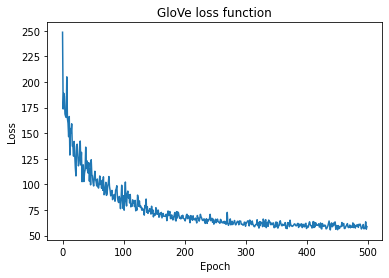

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_loss_fn(losses, "GloVe loss function")

In [ ]:
sentence = "unk1 Hello world unk2"
vec = model.predict(sentence)
print(vec.shape)
vec

torch.Size([4, 2])


tensor([[-0.4238, -1.0120],
        [-0.4238, -1.0120],
        [ 0.0511, -0.5007],
        [-0.4238, -1.0120]])

In [ ]:
word = "time"
vector = get_word(model, word)
vector

tensor([-0.8379, -0.8237])

In [ ]:
closest(model, vector)

[('time', tensor(0.)),
 ('forgotten', tensor(0.0119)),
 ('join', tensor(0.0550)),
 ('rarer', tensor(0.0702)),
 ('centuries', tensor(0.0709)),
 ('complicated', tensor(0.0766)),
 ('originated', tensor(0.1026)),
 ('light-years', tensor(0.1072)),
 ('transportation', tensor(0.1093)),
 ('throng', tensor(0.1175))]

In [ ]:
analogy(model, "when", "time", "who")


[when : time :: who : ?]
(0.0661) taking
(0.1178) ash
(0.1646) ended
(0.1789) again
(0.1795) well


In [ ]:
#ix_to_word = {i: word for i, word in enumerate(model.vocab)}

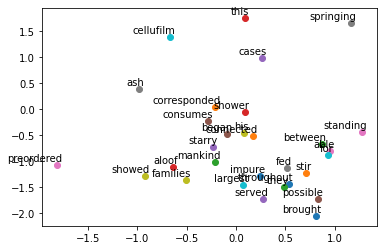

In [ ]:
N_WORDS = 30
# Visualize embeddings
#if EMBEDDING_SIZE == 2:
if True :
  # Pick some random words
	word_inds = np.random.choice(np.arange(len(vocab)), size = N_WORDS, replace=False)
	for word_ind in word_inds:
		w_embed = model.embeddings()[word_ind].numpy()
		x, y = w_embed[0], w_embed[1]
		plt.scatter(x, y)
		plt.annotate(model.ix_to_word[word_ind], xy=(x, y), xytext=(5, 2),
			textcoords='offset points', ha='right', va='bottom')
	plt.savefig("glove.png")

* GloVe: Global Vectors for Word Representation \
Jeffrey Pennington, Richard Socher, Christopher Manning \
https://www.aclweb.org/anthology/D14-1162/
* http://www.foldl.me/2014/glove-python/
* https://github.com/balazs-vida/glove-pytorch
* https://github.com/spro/practical-pytorch/blob/master/glove-word-vectors/glove-word-vectors.ipynb